# Fashion MNIST test

Compare performance of Softmax Regression net vs Pytorch [Quickstart net](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Load Data

Fashion MNIST Dataset

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 64
n_epochs = 15

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
num_classes = len(training_data.classes)
print(f"There are {num_classes} classes in training data")

There are 10 classes in training data


# Model 1

In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
# Define model
class NeuralNetwork_1(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=28*28, out_features=num_outputs)
        )

    def forward(self, x):
        return self.net(x)

In [7]:
model = NeuralNetwork_1(num_classes).to(device)
print(model)

NeuralNetwork_1(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [8]:
total_params = sum(
    param.numel() for param in model.parameters()
)
print(f"Total number of model parameters: {total_params}")

Total number of model parameters: 7850


# Training

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.373038  [   64/60000]
loss: 2.151287  [ 6464/60000]
loss: 1.934603  [12864/60000]
loss: 1.871177  [19264/60000]
loss: 1.693854  [25664/60000]
loss: 1.587238  [32064/60000]
loss: 1.572145  [38464/60000]
loss: 1.454380  [44864/60000]
loss: 1.479632  [51264/60000]
loss: 1.342386  [57664/60000]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.357072 

Epoch 2
-------------------------------
loss: 1.430037  [   64/60000]
loss: 1.391775  [ 6464/60000]
loss: 1.212328  [12864/60000]
loss: 1.318021  [19264/60000]
loss: 1.160671  [25664/60000]
loss: 1.156330  [32064/60000]
loss: 1.189424  [38464/60000]
loss: 1.119295  [44864/60000]
loss: 1.181041  [51264/60000]
loss: 1.077863  [57664/60000]
Test Error: 
 Accuracy: 67.5%, Avg loss: 1.098557 

Epoch 3
-------------------------------
loss: 1.159160  [   64/60000]
loss: 1.172377  [ 6464/60000]
loss: 0.973906  [12864/60000]
loss: 1.134491  [19264/60000]
loss: 0.979220  [25664/60000]
loss: 0.995568  [32064/600

# Inference

In [13]:
classes = training_data.classes

In [14]:
# Remember that you must call model.eval() to set dropout and 
# batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
model.eval()

preds = []
targets = []
for X, y in iter(test_data):
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        preds.append(model(X.to(device)).argmax(axis=1).item())
        targets.append(y)

In [15]:
wrongs = [i for i, (x, y) in enumerate(zip(preds, targets)) if y != x]
corrects = [i for i, (x, y) in enumerate(zip(preds, targets)) if y == x]

# Visualization

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

transform = transforms.ToPILImage()

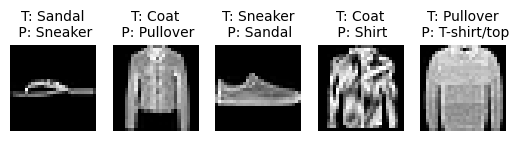

In [17]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[wrongs[i]][0])
    ax[i].set_title(f"T: {classes[targets[wrongs[i]]]}\n P: {classes[preds[wrongs[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

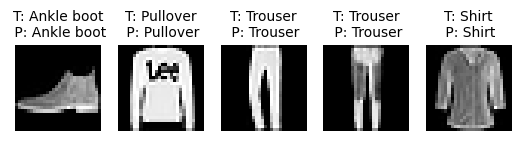

In [18]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[corrects[i]][0])
    ax[i].set_title(f"T: {classes[targets[corrects[i]]]}\n P: {classes[preds[corrects[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

# Model 2

This is the model proposed in the Quickstart guide

In [19]:
# Define model
class NeuralNetwork_2(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_outputs)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [20]:
model = NeuralNetwork_2(num_classes).to(device)
print(model)

NeuralNetwork_2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
total_params = sum(
    param.numel() for param in model.parameters()
)

print(f"Total number of model parameters: {total_params}")

Total number of model parameters: 669706


Notice that it has a lot more parameters to adjust.

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.281782  [   64/60000]
loss: 2.278441  [ 6464/60000]
loss: 2.253567  [12864/60000]
loss: 2.257958  [19264/60000]
loss: 2.236773  [25664/60000]
loss: 2.191029  [32064/60000]
loss: 2.211720  [38464/60000]
loss: 2.161006  [44864/60000]
loss: 2.167443  [51264/60000]
loss: 2.146193  [57664/60000]
Test Error: 
 Accuracy: 43.4%, Avg loss: 2.128087 

Epoch 2
-------------------------------
loss: 2.129328  [   64/60000]
loss: 2.121151  [ 6464/60000]
loss: 2.064752  [12864/60000]
loss: 2.091619  [19264/60000]
loss: 2.029720  [25664/60000]
loss: 1.966961  [32064/60000]
loss: 1.999089  [38464/60000]
loss: 1.908660  [44864/60000]
loss: 1.924878  [51264/60000]
loss: 1.860765  [57664/60000]
Test Error: 
 Accuracy: 59.1%, Avg loss: 1.846035 

Epoch 3
-------------------------------
loss: 1.871913  [   64/60000]
loss: 1.842241  [ 6464/60000]
loss: 1.729808  [12864/60000]
loss: 1.779742  [19264/60000]
loss: 1.663682  [25664/60000]
loss: 1.622318  [32064/600

# Inference

In [24]:
classes = training_data.classes

In [25]:
# Remember that you must call model.eval() to set dropout and 
# batch normalization layers to evaluation mode before running inference. 
# Failing to do this will yield inconsistent inference results.
model.eval()

preds = []
targets = []
for X, y in iter(test_data):
    with torch.no_grad(): # Context-manager that disabled gradient calculation.
        preds.append(model(X.to(device)).argmax(axis=1).item())
        targets.append(y)

In [26]:
wrongs = [i for i, (x, y) in enumerate(zip(preds, targets)) if y != x]
corrects = [i for i, (x, y) in enumerate(zip(preds, targets)) if y == x]

# Visualization

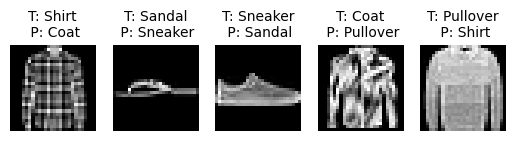

In [27]:
n_samples = 5
fig, ax = plt.subplots(1, n_samples)
for i in range(0, n_samples):
    img = transform(test_data[wrongs[i]][0])
    ax[i].set_title(f"T: {classes[targets[wrongs[i]]]}\n P: {classes[preds[wrongs[i]]]}", fontsize=10)
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')

# Conclusion

The softmax implementation has considerably less parameters to tune and yields a slightly better accuracy when compared to the multilayer perceptron model proposed in Quickstart guide.